In [670]:
# Importing libraries
import numpy as np
import pandas as pd
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score, f1_score
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest, SelectPercentile, RFE, SelectFromModel,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


%matplotlib inline

In [671]:
# Reading the train.csv by removing the
# last column since it's an empty column
training_data = pd.read_csv("data/symptoms_Data_Training.csv")

In [672]:
training_data.head(1)

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,Unnamed: 133
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,NaN


In [673]:
training_data.drop(training_data.columns[-1], axis=1,inplace=True)
training_data.head(1)

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Fungal infection


In [674]:
def data_processing(data):
    # List of target labels
    target_labels = ["Diabetes", "Hypertension"]

    # 1. Change all rows not in target labels to "not ill"
    data["prognosis"] = data["prognosis"].apply(
        lambda x: x if x in target_labels else "not ill"
    )

    # Separate majority and minority classes
    majority = data[data["prognosis"] == "not ill"]
    minority_Hypertension = data[data["prognosis"] == "Hypertension"]
    minority_Diabetes = data[data["prognosis"] == "Diabetes"]

    # Upsample minority class
    minority_upsampled_Diabetes = resample(
        minority_Diabetes, replace=True, n_samples=len(majority), random_state=42
    )
    minority_upsampled_Hypertension = resample(
        minority_Hypertension, replace=True, n_samples=len(majority), random_state=42
    )

    # Combine with majority class
    data = pd.concat(
        [majority, minority_upsampled_Diabetes, minority_upsampled_Hypertension]
    )

    print(data["prognosis"].value_counts())

    return data

In [675]:
data = data_processing(training_data)

prognosis
not ill         4680
Diabetes        4680
Hypertension    4680
Name: count, dtype: int64


In [676]:
# Data types and non-null counts
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14040 entries, 0 to 1746
Columns: 133 entries, itching to prognosis
dtypes: int64(132), object(1)
memory usage: 14.4+ MB
None


In [677]:
# Summary for binary columns
data.describe()

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,pus_filled_pimples,blackheads,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze
count,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,...,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000,14040.000000
mean,0.048291,0.055983,0.007692,0.015812,0.007692,0.056838,0.048718,0.015812,0.015812,0.007692,...,0.007692,0.007692,0.007692,0.008120,0.008120,0.008120,0.008120,0.008120,0.008120,0.008120
std,0.214387,0.229897,0.087371,0.124752,0.087371,0.231540,0.215285,0.124752,0.124752,0.087371,...,0.087371,0.087371,0.087371,0.089746,0.089746,0.089746,0.089746,0.089746,0.089746,0.089746
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [678]:
# Check for missing values in each column
data.isnull().sum()

itching                 0
skin_rash               0
nodal_skin_eruptions    0
continuous_sneezing     0
shivering               0
                       ..
inflammatory_nails      0
blister                 0
red_sore_around_nose    0
yellow_crust_ooze       0
prognosis               0
Length: 133, dtype: int64

In [679]:
for col in data.columns[:-1]:  # Exclude the last object column
    print(f"{col}:\n{data[col].value_counts()}\n")

itching:
itching
0    13362
1      678
Name: count, dtype: int64

skin_rash:
skin_rash
0    13254
1      786
Name: count, dtype: int64

nodal_skin_eruptions:
nodal_skin_eruptions
0    13932
1      108
Name: count, dtype: int64

continuous_sneezing:
continuous_sneezing
0    13818
1      222
Name: count, dtype: int64

shivering:
shivering
0    13932
1      108
Name: count, dtype: int64

chills:
chills
0    13242
1      798
Name: count, dtype: int64

joint_pain:
joint_pain
0    13356
1      684
Name: count, dtype: int64

stomach_pain:
stomach_pain
0    13818
1      222
Name: count, dtype: int64

acidity:
acidity
0    13818
1      222
Name: count, dtype: int64

ulcers_on_tongue:
ulcers_on_tongue
0    13932
1      108
Name: count, dtype: int64

muscle_wasting:
muscle_wasting
0    13932
1      108
Name: count, dtype: int64

vomiting:
vomiting
0    12126
1     1914
Name: count, dtype: int64

burning_micturition:
burning_micturition
0    13824
1      216
Name: count, dtype: int64

spotting_uri

In [680]:
print(data.columns.tolist())

['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing', 'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting', 'vomiting', 'burning_micturition', 'spotting_urination', 'fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets', 'mood_swings', 'weight_loss', 'restlessness', 'lethargy', 'patches_in_throat', 'irregular_sugar_level', 'cough', 'high_fever', 'sunken_eyes', 'breathlessness', 'sweating', 'dehydration', 'indigestion', 'headache', 'yellowish_skin', 'dark_urine', 'nausea', 'loss_of_appetite', 'pain_behind_the_eyes', 'back_pain', 'constipation', 'abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine', 'yellowing_of_eyes', 'acute_liver_failure', 'fluid_overload', 'swelling_of_stomach', 'swelled_lymph_nodes', 'malaise', 'blurred_and_distorted_vision', 'phlegm', 'throat_irritation', 'redness_of_eyes', 'sinus_pressure', 'runny_nose', 'congestion', 'chest_pain', 'weakness_in_limbs', 'fast_heart_rate', 'pain_during_bowe

In [681]:
# correlation_matrix = data.iloc[:, :-1].corr()
# # Create a heatmap of the correlation matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix for Iris Dataset')
# plt.show()

In [682]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
# plt.title("Correlation Matrix of Binary Features")
# plt.show()


In [683]:
# # Bar plots for each binary feature grouped by the Category
# for col in data.columns[:-1]:
#     sns.barplot(x='prognosis', y=col, data=data)
#     plt.title(f"Distribution of {col} by prognosis")
#     plt.show()


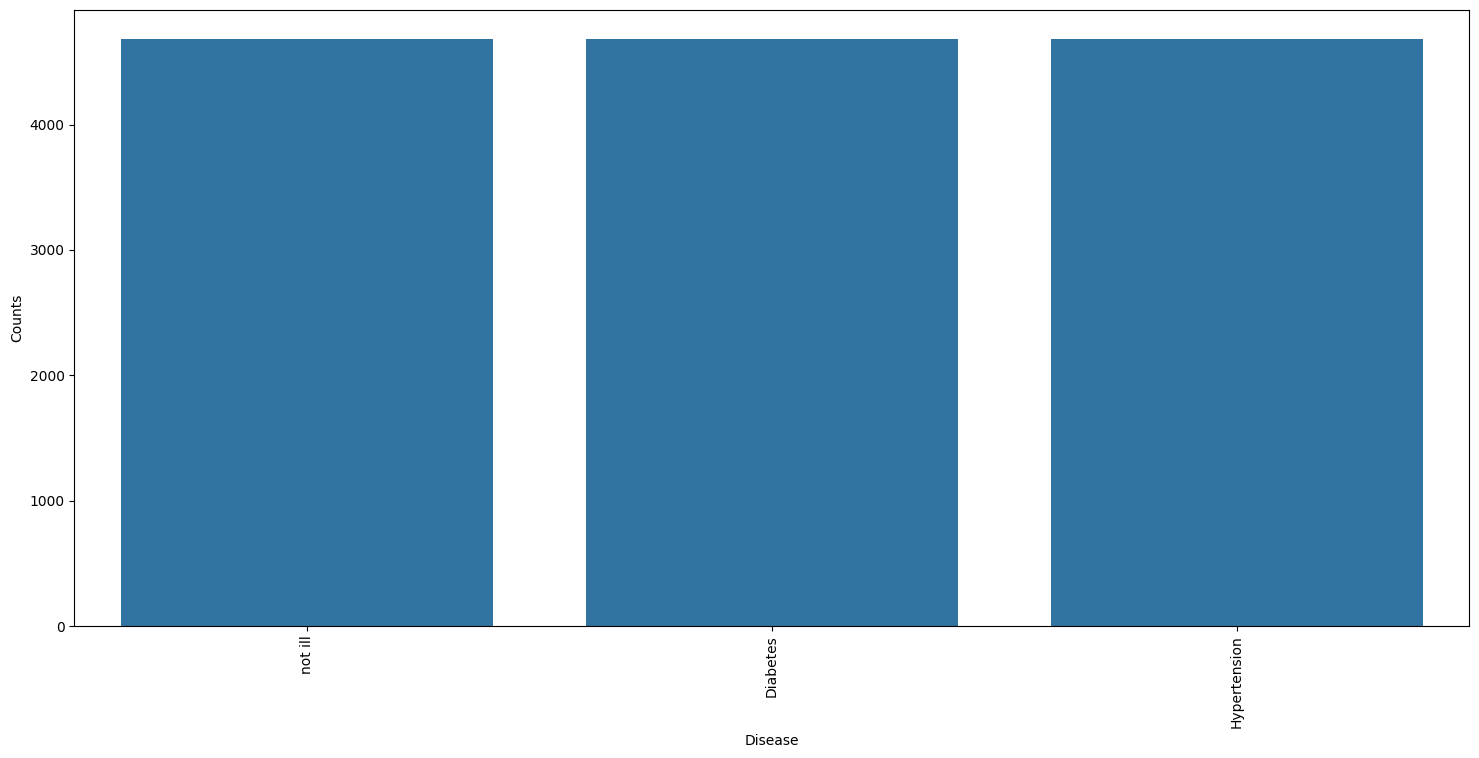

In [684]:
# Checking whether the dataset is balanced or not
disease_counts = data["prognosis"].value_counts()
temp_df = pd.DataFrame({
    "Disease": disease_counts.index,
    "Counts": disease_counts.values
})

plt.figure(figsize = (18,8))
sns.barplot(x = "Disease", y = "Counts", data = temp_df)
plt.xticks(rotation=90)
plt.show()


In [685]:
# Encoding the target value into numerical
# value using LabelEncoder
encoder = LabelEncoder()
data["prognosis"] = encoder.fit_transform(data["prognosis"])


In [686]:
XX = data.iloc[:,:-1]
y = data.iloc[:, -1]

In [687]:
# sama

# Assume X is your feature matrix and y is your target variable
selector = SelectKBest(score_func=chi2, k=10)  # Select top 10 features
X = selector.fit_transform(XX, y)

# Get scores and feature indices
scores = selector.scores_
selected_features = selector.get_support(indices=True)
print("Selected feature indices:", selected_features)
# print("Feature scores:", scores)
selected_columns = XX.columns[selector.get_support()].tolist()
print("Selected columns:", selected_columns)


Selected feature indices: [ 19  20  21  23  49  67  85 104 105 109]
Selected columns: ['weight_loss', 'restlessness', 'lethargy', 'irregular_sugar_level', 'blurred_and_distorted_vision', 'obesity', 'loss_of_balance', 'increased_appetite', 'polyuria', 'lack_of_concentration']


In [688]:
# SPercentile = SelectPercentile(score_func = chi2, percentile=65)
# X = SPercentile.fit_transform(XX,y)

# cols = SPercentile.get_support(indices=True)

# selected_columns = XX.columns[SPercentile.get_support()].tolist()
# print("Selected columns:", selected_columns)

In [689]:
# # RFE (Recursive Feature Elimination)
# estimator = LogisticRegression(max_iter=1000) # Base estimator
# selector_rfe = RFE(estimator=estimator, n_features_to_select=2) # Select top 2 features
# X_train_rfe = selector_rfe.fit_transform(XX, y)

In [690]:
X_train, X_test, y_train, y_test =train_test_split(
  X, y, test_size = 0.2, random_state = 42)

print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: (11232, 10), (11232,)
Test: (2808, 10), (2808,)


In [691]:
# Defining scoring metric for k-fold cross validation
def cv_scoring(estimator, X, y):
    return accuracy_score(y, estimator.predict(X))

# Initializing Models
models = {
    "SVC":SVC(),
    "Gaussian NB":GaussianNB(),
    "Random Forest":RandomForestClassifier(random_state=18),
    "Decision Tree":DecisionTreeClassifier(criterion="gini")
}

# Producing cross validation score for the models
for model_name in models:
    model = models[model_name]
    scores = cross_val_score(model, X, y, cv = 10,
                             n_jobs = -1,
                             scoring = cv_scoring)
    print("=="*30)
    print(model_name)
    print(f"Scores: {scores}")
    print(f"Mean Score: {np.mean(scores)}")


SVC
Scores: [0.98717949 0.98076923 0.98005698 0.98148148 0.98076923 0.98290598
 0.97792023 0.98290598 0.98290598 0.98290598]
Mean Score: 0.981980056980057
Gaussian NB
Scores: [0.72507123 0.74430199 0.73433048 0.75       0.73005698 0.74358974
 0.74358974 0.74358974 0.74358974 0.74358974]
Mean Score: 0.7401709401709402
Random Forest
Scores: [0.98717949 0.98076923 0.98005698 0.98148148 0.98076923 0.98290598
 0.97792023 0.98290598 0.98290598 0.98290598]
Mean Score: 0.981980056980057
Decision Tree
Scores: [0.98717949 0.98076923 0.98005698 0.98148148 0.98076923 0.98290598
 0.97792023 0.98290598 0.98290598 0.98290598]
Mean Score: 0.981980056980057


In [692]:
# Training and testing SVM Classifier
svm_model = SVC()
svm_model.fit(X_train, y_train)
preds = svm_model.predict(X_test)

print(
    f"Accuracy on train data by SVM Classifier: {accuracy_score(y_train, svm_model.predict(X_train))*100}\
     precision on train data by SVM Classifier: {precision_score(y_train, svm_model.predict(X_train),average="weighted")*100}\
     recall score on train data by SVM Classifier: {recall_score(y_train, svm_model.predict(X_train),average="weighted")*100} \
     f1 score on train data by SVM Classifier: {f1_score(y_train, svm_model.predict(X_train),average="weighted")*100}"
)

print(
    f"Accuracy on test data by SVM Classifier: {accuracy_score(y_test, preds)*100}\
     precision_score on test data by SVM Classifier: {precision_score(y_test, preds,average="weighted")*100}\
     recall_score on test data by SVM Classifier: {recall_score(y_test, preds,average="weighted")*100}\
     f1_score on test data by SVM Classifier: {f1_score(y_test, preds,average="weighted")*100}"
)
# cf_matrix = confusion_matrix(y_test, preds)
# plt.figure(figsize=(12, 8))
# sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix for SVM Classifier on Test Data")
# plt.show()

# Training and testing Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
preds = nb_model.predict(X_test)
print(
    f"Accuracy on train data by GaussianNB Classifier: {accuracy_score(y_train, nb_model.predict(X_train))*100}\
     precision_score on train data by GaussianNB Classifier: {precision_score(y_train, nb_model.predict(X_train),average="weighted")*100}\
     recall_score on train data by GaussianNB Classifier: {recall_score(y_train, nb_model.predict(X_train),average="weighted")*100}\
     f1_score on train data by GaussianNB Classifier: {f1_score(y_train, nb_model.predict(X_train),average="weighted")*100}"
)

print(
    f"Accuracy on test data by Naive Bayes Classifier: {accuracy_score(y_test, preds)*100}\
     precision_score on test data by Naive Bayes Classifier: {precision_score(y_test, preds,average="weighted")*100}\
     recall_score on test data by Naive Bayes Classifier: {recall_score(y_test, preds,average="weighted")*100}\
     f1_score on test data by Naive Bayes Classifier: {f1_score(y_test, preds,average="weighted")*100}"
)
# cf_matrix = confusion_matrix(y_test, preds)
# plt.figure(figsize=(12, 8))
# sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix for Naive Bayes Classifier on Test Data")
# plt.show()

# Training and testing Random Forest Classifier
rf_model = RandomForestClassifier(random_state=18)
rf_model.fit(X_train, y_train)
preds = rf_model.predict(X_test)
print(
    f"Accuracy on train data by Random Forest Classifier: {accuracy_score(y_train, rf_model.predict(X_train))*100}\
     precision_score on train data by Random Forest Classifier: {precision_score(y_train, rf_model.predict(X_train),average="weighted")*100}\
     recall_score on train data by Random Forest Classifier: {recall_score(y_train, rf_model.predict(X_train),average="weighted")*100}\
     f1_score on train data by Random Forest Classifier: {f1_score(y_train, rf_model.predict(X_train),average="weighted")*100}"
)

print(
    f"Accuracy on test data by Random Forest Classifier: {accuracy_score(y_test, preds)*100}\
     precision_score on test data by Random Forest Classifier: {precision_score(y_test, preds,average="weighted")*100}\
     recall_score on test data by Random Forest Classifier: {recall_score(y_test, preds,average="weighted")*100}\
     f1_score on test data by Random Forest Classifier: {f1_score(y_test, preds,average="weighted")*100}"
)

# Training and testing Random Forest Classifier
dt_model = DecisionTreeClassifier(criterion="gini")
dt_model.fit(X_train, y_train)
preds = dt_model.predict(X_test)
print(
    f"Accuracy on train data by Random Forest Classifier: {accuracy_score(y_train, dt_model.predict(X_train))*100}\
     precision_score on train data by Random Forest Classifier: {precision_score(y_train, dt_model.predict(X_train),average="weighted")*100}\
     recall_score on train data by Random Forest Classifier: {recall_score(y_train, dt_model.predict(X_train),average="weighted")*100}\
     f1_score on train data by Random Forest Classifier: {f1_score(y_train, dt_model.predict(X_train),average="weighted")*100}"
)

print(
    f"Accuracy on test data by Random Forest Classifier: {accuracy_score(y_test, preds)*100}\
     precision_score on test data by Random Forest Classifier: {precision_score(y_test, preds,average="weighted")*100}\
     recall_score on test data by Random Forest Classifier: {recall_score(y_test, preds,average="weighted")*100}\
     f1_score on test data by Random Forest Classifier: {f1_score(y_test, preds,average="weighted")*100}"
)

# cf_matrix = confusion_matrix(y_test, preds)
# plt.figure(figsize=(12, 8))
# sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
# plt.show()

Accuracy on train data by SVM Classifier: 98.40633903133903     precision on train data by SVM Classifier: 98.47877816627818     recall score on train data by SVM Classifier: 98.40633903133903      f1 score on train data by SVM Classifier: 98.40528026583122
Accuracy on test data by SVM Classifier: 98.25498575498575     precision_score on test data by SVM Classifier: 98.34313595911533     recall_score on test data by SVM Classifier: 98.25498575498575     f1_score on test data by SVM Classifier: 98.25449718463871
Accuracy on train data by GaussianNB Classifier: 73.98504273504274     precision_score on train data by GaussianNB Classifier: 85.36293603368142     recall_score on train data by GaussianNB Classifier: 73.98504273504274     f1_score on train data by GaussianNB Classifier: 69.2501783156964
Accuracy on test data by Naive Bayes Classifier: 74.14529914529915     precision_score on test data by Naive Bayes Classifier: 85.5420889573895     recall_score on test data by Naive Bayes Clas

In [693]:
# test data preprocessing
test_data = pd.read_csv("data/symptoms_Data_Testing.csv")
test_data = data_processing(test_data)
test_X = test_data.iloc[:, :-1]
test_Y = encoder.transform(test_data.iloc[:, -1])

prognosis
not ill         40
Diabetes        40
Hypertension    40
Name: count, dtype: int64


In [694]:
test_X = selector.fit_transform(test_X, test_Y)
selected_features = selector.get_support(indices=True)

In [695]:
# test_X = SPercentile.fit_transform(test_X,test_Y)

# selected_features = SPercentile.get_support(indices=True)
# selected_features

In [700]:
# Training the models on whole data
final_svm_model = SVC()
final_nb_model = GaussianNB()
final_rf_model = RandomForestClassifier(random_state=18)
final_dt_model = DecisionTreeClassifier(criterion="gini")
final_svm_model.fit(X, y)
final_nb_model.fit(X, y)
final_rf_model.fit(X, y)
final_dt_model.fit(X, y)

# Making prediction by take mode of predictions
# made by all the classifiers
svm_preds = final_svm_model.predict(test_X)
nb_preds = final_nb_model.predict(test_X)
rf_preds = final_rf_model.predict(test_X)
dt_preds = final_dt_model.predict(test_X)


from scipy import stats

final_preds = [
    stats.mode([i, j, k])[0] for i, j, k in zip(svm_preds, dt_preds, rf_preds)
]

print(
    f"Accuracy on Test dataset by the combined model: {accuracy_score(test_Y, final_preds)*100}\
     precision_score on Test dataset by the combined model: {precision_score(test_Y, final_preds,average="weighted")*100}\
     recall_score on Test dataset by the combined model: {recall_score(test_Y, final_preds,average="weighted")*100}\
     f1_score on Test dataset by the combined model: {f1_score(test_Y, final_preds,average="weighted")*100}"
)

# cf_matrix = confusion_matrix(test_Y, final_preds)
# plt.figure(figsize=(12, 8))

# sns.heatmap(cf_matrix, annot=True)
# plt.title("Confusion Matrix for Combined Model on Test Dataset")
# plt.show()

Accuracy on Test dataset by the combined model: 98.33333333333333     precision_score on Test dataset by the combined model: 98.41269841269842     recall_score on Test dataset by the combined model: 98.33333333333333     f1_score on Test dataset by the combined model: 98.33229101521785


In [708]:
symptoms = selected_columns


import random

# Randomly select 3 values
if len(selected_columns) >= 3:
    random_values = random.sample(selected_columns, 3)
    print("Randomly selected columns:", random_values)
else:
    print("The list has fewer than 3 elements.")

# Creating a symptom index dictionary to encode the
# input symptoms into numerical form
symptom_index = {}
for index, value in enumerate(symptoms):
    symptom_index[value] = index

data_dict = {"symptom_index": symptom_index, "predictions_classes": encoder.classes_}


# Defining the Function
# Input: string containing symptoms separated by commas
# Output: Generated predictions by models
def predictDisease(symptoms):
    # creating input data for the models
    input_data = [0] * len(data_dict["symptom_index"])
    for symptom in symptoms:
        index = data_dict["symptom_index"][symptom]
        input_data[index] = 1

    # reshaping the input data and converting it
    # into suitable format for model predictions
    input_data = np.array(input_data).reshape(1, -1)

    # generating individual outputs
    rf_prediction = data_dict["predictions_classes"][
        final_rf_model.predict(input_data)[0]
    ]
    svm_prediction = data_dict["predictions_classes"][
        final_svm_model.predict(input_data)[0]
    ]
    dt_prediction = data_dict["predictions_classes"][
        final_dt_model.predict(input_data)[0]
    ]

    # making final prediction by taking mode of all predictions
    # Use statistics.mode instead of scipy.stats.mode
    import statistics

    final_prediction = statistics.mode([rf_prediction, svm_prediction])
    predictions = {
        "rf_model_prediction": rf_prediction,
        "svm_model_prediction": svm_prediction,
        "dt_model_prediction": dt_prediction,
        "final_prediction": final_prediction,
    }
    return predictions


# Testing the function
print(
    predictDisease(random_values)
)

Randomly selected columns: ['loss_of_balance', 'blurred_and_distorted_vision', 'lack_of_concentration']
{'rf_model_prediction': 'Hypertension', 'svm_model_prediction': 'Hypertension', 'dt_model_prediction': 'Hypertension', 'final_prediction': 'Hypertension'}
